# ECOGAL catalogue demonstration and query using DJA API
  

## Short description of the project: 
ECOGAL (**ECO**ology for **G**alaxies using **A**LMA archive and **L**egacy surveys) is an ALMA data-mining effort that uniformly reduces archival data, creates science-ready ALMA images, and links them to JWST/HST legacy datasets in well-studied survey fields.

This notebook provides an introduction to the ECOGAL catalogue, including how to query sources by position and retrieve the summary plots available for ALMA-detected galaxies with DJA spectra. The catalogue released with this post covers galaxies in the three ALMA-accessible CANDELS fields: COSMOS, GOODS-S, and UDS.

- This notebook was tested on python 3.12 version
- Some functions that are used in this notebook can be installed from : [https://github.com/mjastro/ecogal](https://github.com/mjastro/ecogal)
    * or on terminal: 
    
    `python -m pip install git+https://github.com/mjastro/ecogal.git`

> Additional documentation will be released soon. A complete description of the ALMA data reduction and catalogue construction is provided in [Lee et al. (2025)](
https://doi.org/10.48550/arXiv.2511.20751) [arXiv:2511.20751], and should be cited when using the ECOGAL data products. Users should also cite the appropriate survey references (including ALMA project IDs) when making use of the DJA data products.



In [118]:
%matplotlib inline

In [119]:
# libraries to install
if 0:
    !python -m pip install git+https://github.com/mjastro/ecogal.git
    !pip install tabulate
    !pip install git+https://github.com/karllark/dust_attenuation.git

In [120]:
# setting the libraries

import ecogal

import numpy as np
import astropy
import os,sys
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.utils.data import download_file
import astropy.constants as const

import matplotlib as mpl
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astropy.coordinates import Angle


import shapely
from shapely import Point, Polygon


import warnings
from astropy.io import fits
from astropy.wcs import WCS
warnings.filterwarnings('ignore')

import pandas as pd


# cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)


CACHE_DOWNLOADS = True


print(f'astropy version: {astropy.__version__}')

astropy version: 7.1.1


In [121]:
# Set plotting style
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams.update({'font.family':'serif'})
mpl.rcParams.update({'xtick.major.pad': '7.0'})
mpl.rcParams.update({'xtick.major.size': '7.5'})
mpl.rcParams.update({'xtick.major.width': '1.5'})
mpl.rcParams.update({'xtick.minor.pad': '7.0'})
mpl.rcParams.update({'xtick.minor.size': '3.5'})
mpl.rcParams.update({'xtick.minor.width': '1.0'})
mpl.rcParams.update({'ytick.major.pad': '7.0'})
mpl.rcParams.update({'ytick.major.size': '7.5'})
mpl.rcParams.update({'ytick.major.width': '1.5'})
mpl.rcParams.update({'ytick.minor.pad': '7.0'})
mpl.rcParams.update({'ytick.minor.size': '3.5'})
mpl.rcParams.update({'ytick.minor.width': '1.0'})
mpl.rcParams.update({'xtick.labelsize':14})
mpl.rcParams.update({'ytick.labelsize':14})

mpl.rcParams.update({'xtick.direction':'in'})
mpl.rcParams.update({'ytick.direction':'in'})

mpl.rcParams.update({'axes.labelsize' :18})

In [122]:
# to get DJA spectra information

from urllib import request

####Needed to load spectra
import msaexp
import msaexp.spectrum

#to get DJA slit information

import grizli
from grizli import utils


print(f'grizli version: {grizli.__version__}')


grizli version: 1.13.2


# Catalogue data exploration

## Read the table

In [123]:
# prior catalogue which includes all sources with flux constraints (including non-detection) based on the source positions determined by JWST/HST detection

version ='v1' #initial data release

URL_PREFIX = "https://s3.amazonaws.com/alma-ecogal/dr1"
file_cat = "ecogal_all_priors_"+version+".csv"

if 0:
    # the latest zenodo (frozen) catalogue is available here (TBD)
    # this include blind catalogue, and detection catalogue
    URL_PREFIX = "https://zenodo.org/records/XXX"

table_url = f"{URL_PREFIX}/catalogue/{file_cat}"

tab = utils.read_catalog(download_file(table_url, cache=CACHE_DOWNLOADS), format='csv')


### Column descriptions

In [124]:
columns_url = f"{URL_PREFIX}/catalogue/ecogal_{version}.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=CACHE_DOWNLOADS), format='csv')

# Set column metadata
for row in tab_columns:
    col = row['column']
    if row['unit'] != '--':
        tab[col].unit = row['unit']
    if row['description'] != '--':
        tab[col].description = row['description']

tab.info()

<GTable length=258455>
       name         dtype      unit                                                                                                     description                                                                                                     class     n_bad 
------------------ ------- ------------ ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ ------------ ------
         projectID   str14                                                                                                                                                                                                           ALMA project ID       Column      0
       target_alma   str23                                                                                           ALMA target names without space;if original ALMA program has a sp

## zphot-zspec

In [125]:
### -- getting the unique source and spec-z sources
con_dup = np.array(tab.to_pandas()['id_new'].duplicated())
tab0 = tab[~con_dup]
len(tab0)

128125

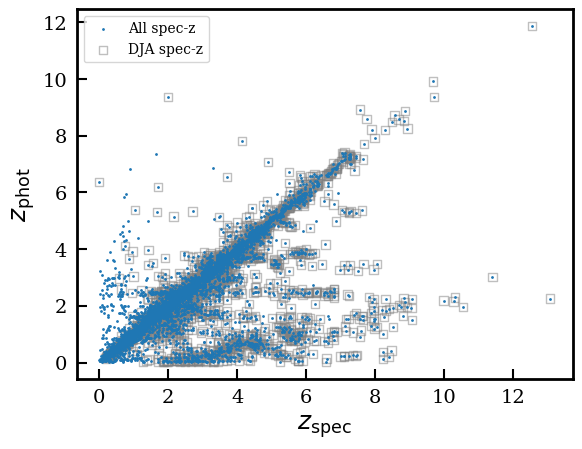

In [126]:
con_z = tab0['zsp_best_avail']>0
con_z &= tab0['z_phot_eazy']>0

con_dja = tab0['zsp_best_survey']=='dja'
con_dja_z = np.logical_and(con_dja,con_z)

plt.scatter(tab0[con_z]['zsp_best_avail'], tab0[con_z]['z_phot_eazy'], s=1, zorder=100, label='All spec-z')
plt.scatter(tab0[con_dja_z]['zsp_best_avail'], tab0[con_dja_z]['z_phot_eazy'], marker='s',facecolor='None',edgecolor='grey',alpha=0.5, label='DJA spec-z')

plt.xlabel(r'$z_{\rm spec}$')
plt.ylabel(r'$z_{\rm phot}$')
plt.legend()

# Query if there is any ALMA coverage given the position

* ALMA/ECOGAL metadata includes information of individual ALMA images such as regions, pixel scales, phase center position, etc.

* This will allow you to check the ALMA/ECOGAL coverage for your source of interest.

In [127]:
# A complete version of the metadata

version='v1'
meta_file = "ecogal_"+version+"_metadata.fits"

table_url = f"{URL_PREFIX}/ancillary/{meta_file}"
meta = utils.read_catalog(download_file(table_url, cache=CACHE_DOWNLOADS), format='fits')
meta[:3]

file_alma,version,simple,bitpix,naxis,naxis1,naxis2,naxis3,extend,bscale,bzero,bmaj,bmin,bpa,btype,object,bunit,equinox,radesys,lonpole,latpole,pc1_1,pc2_1,pc3_1,pc1_2,pc2_2,pc3_2,pc1_3,pc2_3,pc3_3,ctype1,crval1,cdelt1,crpix1,cunit1,ctype2,crval2,cdelt2,crpix2,cunit2,ctype3,crval3,cdelt3,crpix3,cunit3,pv2_1,pv2_2,restfrq,specsys,altrval,altrpix,velref,telescop,observer,date-obs,timesys,obsra,obsdec,obsgeo-x,obsgeo-y,obsgeo-z,instrume,distance,mpiprocs,chnchnks,memreq,memavail,useweigh,date,origin,almaid,is_mosaic,band,footprint,release,is_available,ra_center,dec_center,noise_fit,noise_tot,FoV_sigma
bytes137,bytes4,bool,int64,int64,int64,int64,int64,bool,float64,float64,float64,float64,float64,bytes9,bytes26,bytes7,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes8,float64,float64,float64,bytes3,bytes8,float64,float64,float64,bytes3,bytes4,float64,float64,float64,bytes2,float64,float64,float64,bytes4,float64,float64,int64,bytes4,bytes15,bytes26,bytes3,float64,float64,float64,float64,float64,bytes4,float64,int64,int64,float64,float64,bool,bytes26,bytes30,bytes14,bool,int64,bytes461,bytes3,bool,float64,float64,float64,float64,float64
2011.0.00064.S___concat_all_6_AzTEC-3_0_b7_cont_noninter2sig.image.pbcor.fits,v1.0,True,-32,3,1600,1600,1,True,1.0,0.0,0.0002005813188023,0.0001579564147525,-53.50122070312,Intensity,AzTEC-3,Jy/beam,2000.0,FK5,180.0,2.586833336311,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,RA---SIN,150.0890000048,-2.777777777778e-05,801.0,deg,DEC--SIN,2.586833336311,2.777777777778e-05,801.0,deg,FREQ,296763686486.8,15646751913.56,1.0,Hz,0.0,0.0,296763686486.8,LSRK,-0.0,1.0,257,ALMA,riechers,2012-04-11T01:22:13.632000,UTC,150.0890000048,2.586833336311,2225142.180269,-5440307.370349,-2481029.851874,ALMA,0.0,1,1,0.12359619,150.23436,False,2023-11-14T12:19:42.442402,CASA 6.5.6-22 CASAtools:v1.0.0,2011.0.00064.S,False,7,"((150.088583,2.582778),(150.085914,2.584167),(150.084940,2.587250),(150.086331,2.589917),(150.089417,2.590889),(150.092086,2.589500),(150.093060,2.586417),(150.091669,2.583750),(150.088583,2.582778))",N/A,True,150.0890000048,2.5868333363110025,4.46259777172499e-05,5.5606829846510664e-05,8.332485222950787
2011.0.00064.S___concat_all_6_AzTEC-3_1_b7_cont_noninter2sig.image.pbcor.fits,v1.0,True,-32,3,1600,1600,1,True,1.0,0.0,0.0002007880806923,0.0001580240825812,-53.53054428101,Intensity,AzTEC-3,Jy/beam,2000.0,FK5,180.0,2.588527777932,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,RA---SIN,150.0868750002,-2.777777777778e-05,801.0,deg,DEC--SIN,2.588527777932,2.777777777778e-05,801.0,deg,FREQ,296763687761.7,15646752334.74,1.0,Hz,0.0,0.0,296763687761.7,LSRK,-0.0,1.0,257,ALMA,riechers,2012-04-11T01:22:54.720000,UTC,150.0868750002,2.588527777932,2225142.180269,-5440307.370349,-2481029.851874,ALMA,0.0,1,1,0.12359619,150.1451,False,2023-11-14T13:30:14.601414,CASA 6.5.6-22 CASAtools:v1.0.0,2011.0.00064.S,False,7,"((150.086458,2.584472),(150.083789,2.585861),(150.082815,2.588944),(150.084206,2.591611),(150.087292,2.592583),(150.089961,2.591194),(150.090935,2.588111),(150.089544,2.585444),(150.086458,2.584472))",N/A,True,150.0868750002,2.5885277779320006,6.49289000021855e-05,0.00011714215361280367,8.33248518715434
2011.0.00097.S___concat_all_10_COSMOSLowz_64_29_b7_cont_noninter2sig.image.pbcor.fits,v1.0,True,-32,3,1844,1844,1,True,1.0,0.0,0.0001445855862565,0.0001385951704449,32.57455062866,Intensity,COSMOSLowz_64,Jy/beam,2000.0,FK5,180.0,2.193778888889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,RA---SIN,150.0951,-2.777777777778e-05,923.0,deg,DEC--SIN,2.193778888889,2.777777777778e-05,923.0,deg,FREQ,341959206917.1,15956638554.12,1.0,Hz,0.0,0.0,341959206917.1,LSRK,-0.0,1.0,257,ALMA,nscoville,2012-04-22T02:13:22.032000,UTC,150.0951,2.193778888889,2225142.180269,-5440307.370349,-2481029.851874,ALMA,0.0,--,--,--,--,False,2022-01-18T10:06:48.750999,CASA 5.6.1-8,2011.0.00097.S,True,7,"((150.094822,2.190251),(150.092487,2.191390),(150.091570,2.194057),(150.092709,2.196390),(150.095378,2.197307

### Use `ecogal` function : query metata data based on the coordinates

Use [visualcheck.get_footprint](https://github.com/mjastro/ecogal/blob/7afe6412e2309356766ab7fd702a1831214abf5e/ecogal/visualcheck.py#L34) function.

In [128]:
import ecogal.visualcheck as visualcheck

In [129]:
# get the metadata via DJA
ra, dec = 34.41887, -5.21965
fp,_ = visualcheck.get_footprint(ra,dec)

There are #15 ALMA projects overlapping


In [130]:
fp['file_alma','almaid','object','band']

file_alma,almaid,object,band
bytes137,bytes14,bytes26,int64
2012.1.00245.S__all_SXDF-NB2315-2_b7_cont_noninter2sig.image.pbcor.fits,2012.1.00245.S,SXDF-NB2315-2,7
2012.1.00245.S__all_SXDF-NB2315-3_b7_cont_noninter2sig.image.pbcor.fits,2012.1.00245.S,SXDF-NB2315-3,7
2013.1.00742.S__all_SXDF-B3-NB2315-FoV1_b3_cont_noninter2sig.image.pbcor.fits,2013.1.00742.S,SXDF-B3-NB2315-FoV1,3
2013.1.00781.S__all_SXDS-AzTEC23_b6_cont_noninter2sig.image.pbcor.fits,2013.1.00781.S,SXDS-AzTEC23,6
2015.1.00442.S__all_SXDS-AzTEC28_b6_cont_noninter2sig.image.pbcor.fits,2015.1.00442.S,SXDS-AzTEC28,6
2015.1.01074.S__all_UDSp_17_b7_cont_noninter2sig.image.pbcor.fits,2015.1.01074.S,UDSp_17,7
2015.1.01528.S__all_UDS.0113_b7_cont_noninter2sig.image.pbcor.fits,2015.1.01528.S,UDS.0113,7
2016.1.00434.S__all_UDS.0113_b7_cont_noninter2sig.image.pbcor.fits,2016.1.00434.S,UDS.0113,7
2017.1.00562.S__all_NB2315_b3_cont_noninter2sig.image.pbcor.fits,2017.1.00562.S,NB2315,3


# Get ALMA/ECOGAL cutouts

## Method 1. Using `ecogal`

Use [ecogal.pbcor.show_all_cutouts](https://github.com/mjastro/ecogal/blob/b8f1f842a3447aecc3ed365953184cd66a9bab98/ecogal/pbcor.py#L95) function.

In [131]:
import ecogal.pbcor as ecogal_plot

### [1] JWST RGB + ALMA cutout

In [132]:
# an example of many ALMA coverage
ra, dec = 34.41887, -5.21965

N=15
2013.1.00742.S__all_SXDF-B3-NB2315-FoV1_b3       b3   157x 157  0.04  dx=7.57"
2017.1.00562.S__all_NB2315_b3                    b3   313x 313  0.02  dx=7.57"
2019.1.00337.S__all_AS2UDS0113.1_b3              b3    63x  63  0.10  dx=9.84"
2021.1.00705.S__all_UDS.0113_b4                  b4    33x  33  0.20  dx=6.65"
2015.1.00442.S__all_SXDS-AzTEC28_b6              b6   157x 157  0.04  dx=8.32"
2013.1.00781.S__all_SXDS-AzTEC23_b6              b6   313x 313  0.02  dx=8.33"
2017.1.00562.S__all_NB2315_b6                    b6   313x 313  0.02  dx=4.83"
2016.1.00434.S__all_UDS.0113_b7                  b7   157x 157  0.04  dx=6.65"
2012.1.00245.S__all_SXDF-NB2315-3_b7             b7   313x 313  0.02  dx=9.65"
2015.1.01074.S__all_UDSp_17_b7                   b7   313x 313  0.02  dx=9.75"
2015.1.01528.S__all_UDS.0113_b7                  b7   313x 313  0.02  dx=6.66"
2012.1.00245.S__all_SXDF-NB2315-2_b7             b7   313x 313  0.02  dx=0.15"
2017.1.01027.S__all_U4-16504_b7                

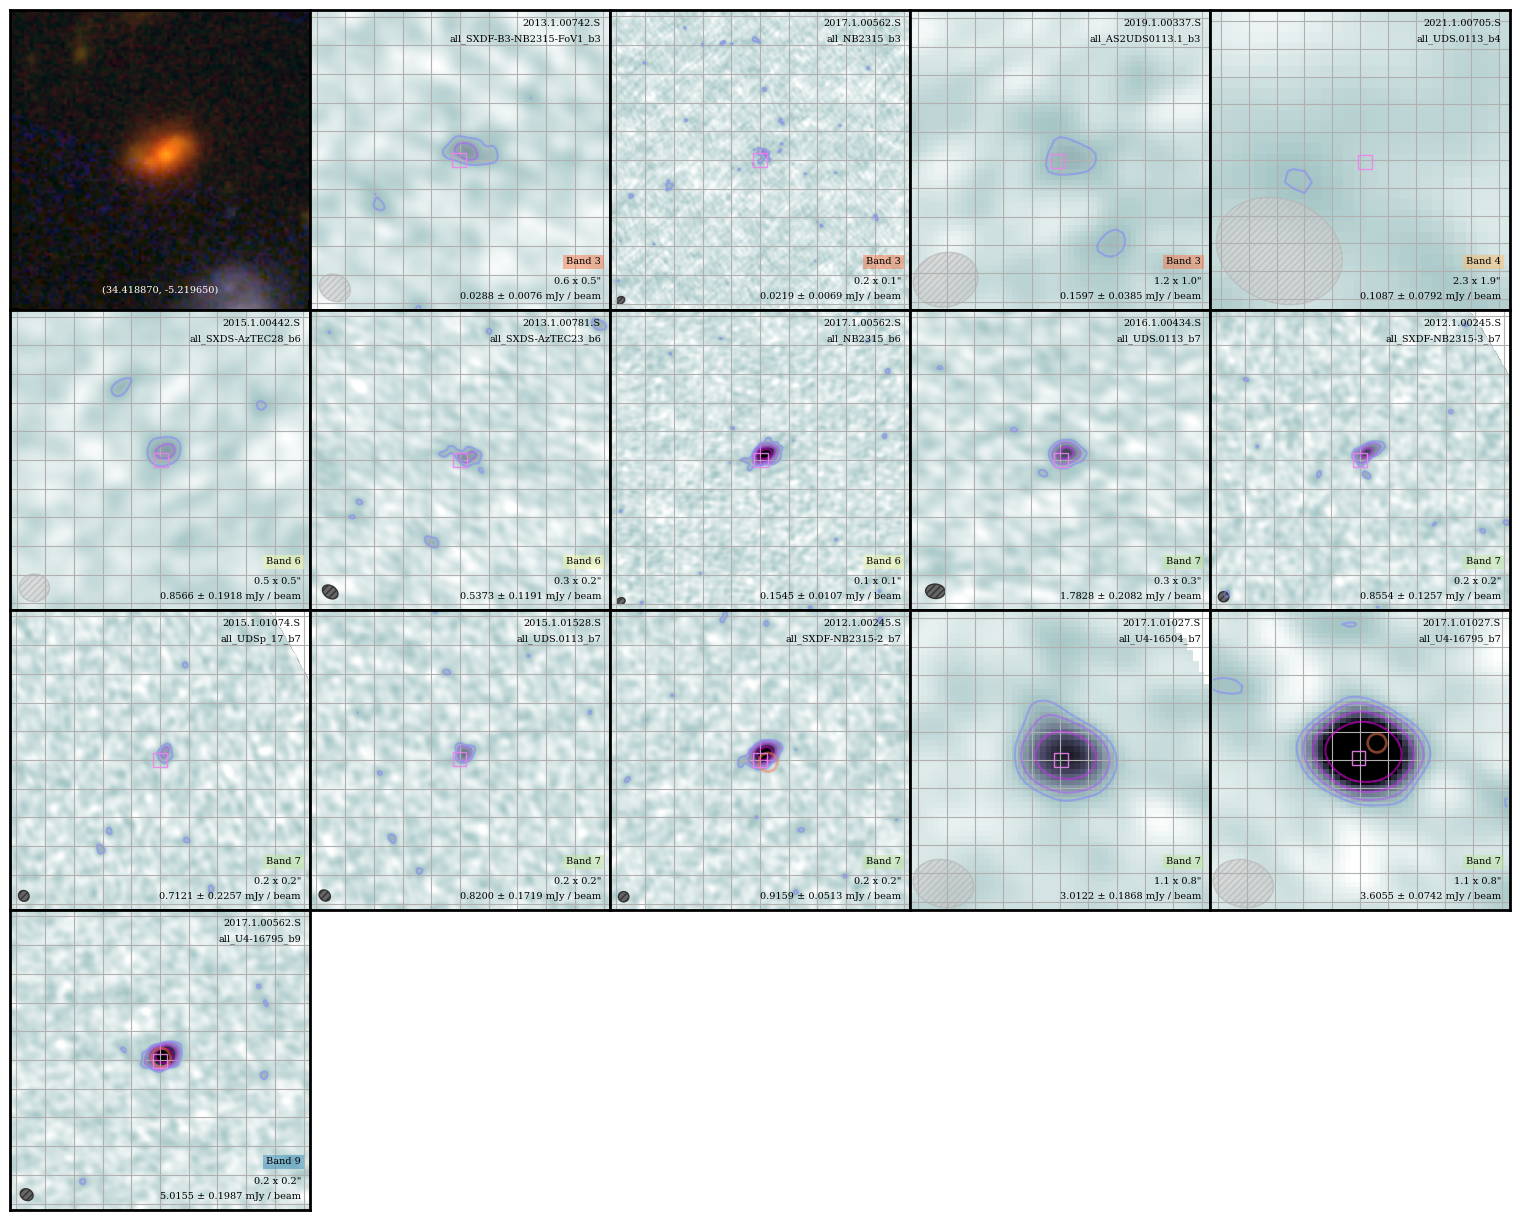

In [133]:
# this example can take a while because it downloads a lot of fits files
summary_cutouts = ecogal_plot.show_all_cutouts(ra,dec)


### [2] Ready-made summary file 

There are some summary png files in the repository made for sources with ALMA detection and DJA spectra (~120 unique sources in total with the first data release), which can be queried by the source position. 

* the default searching area is 0.4 arcsec, that you can change with `r_search`

In [134]:
ra, dec = 150.14325, 2.35599	
_ = visualcheck.get_summary(ra,dec, r_search=0.5)

There are #10 ALMA projects overlapping
There are 9 ECOGAL+DJA cross-match!
https://s3.amazonaws.com/alma-ecogal/dr1/pngs/ecogal__0_all_filters_COSMOS.60520.png
A source found at a distance of = 0.13 arcsec


<img src="https://s3.amazonaws.com/alma-ecogal/dr1/pngs/ecogal__0_all_filters_COSMOS.60520.png" width="70%">

In [135]:
ra, dec = 34.27751, -5.22819
_ = visualcheck.get_summary(ra,dec)

There are #1 ALMA projects overlapping
There are 1 ECOGAL+DJA cross-match!
https://s3.amazonaws.com/alma-ecogal/dr1/pngs/ecogal__0_all_filters_UDS.104633.png
A source found at a distance of = 0.13 arcsec


<img src="https://s3.amazonaws.com/alma-ecogal/dr1/pngs/ecogal__0_all_filters_UDS.104633.png" width="70%">

## Method 2: Getting cutouts and footprint via DJA API

* ALMA footprint can also be retrieved via DJA API: [https://grizli-cutout.herokuapp.com/](https://grizli-cutout.herokuapp.com/)
    * See also the instructions for accessing API (for other projects) : [https://dawn-cph.github.io/dja/general/api_summary/](https://dawn-cph.github.io/dja/general/api_summary/)
* The identifier for ECOCAL is `ecogal`, followed by the output mode and coordinate information `?ra=&dec=`.

There are three different output modes:

* `output=footprint` : footprint for ALMA coverage
* `output=csv` : metadata
* `output=cutout` : making a cutout image
    * for cutout module: specify ALMA file names. The file name is available in the ECOGAL catalogue or from the metadata, and the column name is `file_alma` 

### `footprint` mode
[https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra=34.48016&dec=-5.11252](https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra=34.48016&dec=-5.11252)
### `cutout` mode
Given the ALMA file name of 2015.1.01528.S__all_UDS.0424_b7_cont_noninter2sig.image.pbcor.fits

[https://grizli-cutout.herokuapp.com/ecogal?output=cutout&sx=3.&cutout_size=2.0&ra=34.48016&dec=-5.11252&file_alma=2015.1.01528.S__all_UDS.0424_b7_cont_noninter2sig.image.pbcor.fits](https://grizli-cutout.herokuapp.com/ecogal?output=cutout&sx=3.&cutout_size=2.0&ra=34.48016&dec=-5.11252&file_alma=2015.1.01528.S__all_UDS.0424_b7_cont_noninter2sig.image.pbcor.fits)

In [136]:
from IPython.display import display, Markdown, Latex

In [137]:
# getting the summary of the footprint for a given ra, dec
ra, dec = 34.48016,-5.11252
cord = SkyCoord(ra,dec, unit=(u.degree, u.degree))
ara = tab['RA_peak_alma']
adec = tab['Dec_peak_alma']
acord = SkyCoord(ara, adec, unit=(u.degree, u.degree))
#search for the matching source within 0.1 arcsec
con_pos = acord.separation(cord).arcsec<0.15
ecotb=tab[con_pos]

In [138]:

#  see also the description in the https://dawn-cph.github.io/dja/blog/2025/05/01/nirspec-merged-table-v4/
#  
cutout_URL = f"https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra={ra}&dec={dec}"

ecotb['Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        cutout_URL.format(ra,dec)
    )
    for row in ecotb
]

df = ecotb['projectID','target_alma','id_new','band','beam_maj','sn','separation_prior','zsp_best_avail','z_phot_eazy','Thumb','file_alma'].to_pandas()

display(Markdown(df.to_markdown()))

|    | projectID      | target_alma   | id_new     | band   |   beam_maj |    sn |   separation_prior |   zsp_best_avail |   z_phot_eazy | Thumb                                                                                                         | file_alma                                                              |
|---:|:---------------|:--------------|:-----------|:-------|-----------:|------:|-------------------:|-----------------:|--------------:|:--------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------|
|  0 | 2023.1.01520.S | 0424.0        | UDS.105062 | b4     |       0.69 |  7.08 |               0.09 |           3.5433 |       3.47313 | <img src="https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra=34.48016&dec=-5.11252" height=200px> | 2023.1.01520.S__all_0424.0_b4_cont_noninter2sig.image.pbcor.fits       |
|  1 | 2015.1.01528.S | UDS.0424      | UDS.105062 | b7     |       0.21 | 19.15 |               0.05 |           3.5433 |       3.47313 | <img src="https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra=34.48016&dec=-5.11252" height=200px> | 2015.1.01528.S__all_UDS.0424_b7_cont_noninter2sig.image.pbcor.fits     |
|  2 | 2013.1.00781.S | SXDS-AzTEC28  | UDS.105062 | b6     |       0.32 | 18.72 |               0.06 |           3.5433 |       3.47313 | <img src="https://grizli-cutout.herokuapp.com/ecogal?output=footprint&ra=34.48016&dec=-5.11252" height=200px> | 2013.1.00781.S__all_SXDS-AzTEC28_b6_cont_noninter2sig.image.pbcor.fits |

# Access the ALMA/ECOGAL image fits files
* All fits files (primary beam corrected) are available from the DJA repository (on AWS server) and a frozen version will be available on Zenodo.

In [139]:
#getting the corresponding file name from the catalogue
#some times the file name includes special string like "+", which should be parsed to download the fits file

idx = 2
file_alma = ecotb['file_alma'][idx]
encoded_filename = file_alma.replace("+", "%2B")

In [140]:
fits_URL = "https://s3.amazonaws.com/alma-ecogal/dr1/pbcor/"

almafits = fits.open(
    download_file(str(os.path.join(fits_URL, encoded_filename)), cache=True)
                    )

In [141]:
img = almafits[0].data[0]
hdr = almafits[0].header
wcs_alma = WCS(hdr)

gid = tab[con_pos]['id_new'][idx]
band = tab[con_pos]['band'][idx]
zgal = tab[con_pos]['zsp_best_avail'][idx]
lmass = np.log10(tab[con_pos]['mass_ez'][idx])
sfr = tab[con_pos]['sfr_ez'][idx]

#get the noise of the map (after pb-correction)
noise = tab[con_pos]['noise'][idx]

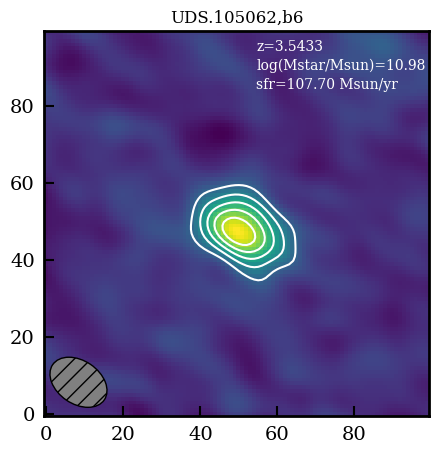

In [142]:
##################
## plotting; think about adding a function
##################

x,y,_= wcs_alma.wcs_world2pix(ra,dec,0,0)
pixsz = np.abs(hdr['CDELT1']*3600)
imsz = 1/pixsz

noise_array = noise*np.arange(4,30,3)
cutout = img[int(y-imsz):int(y+imsz),int(x-imsz):int(x+imsz)]

fig=plt.figure(1,figsize=(5,5))
ax=plt.subplot(111)

ax.imshow(cutout, origin='lower')
ax.contour(cutout, levels = noise_array, colors='white')
ax.set_title(f'{gid},{band}')
ax.text(0.55,0.95, f'z={zgal}', transform=ax.transAxes, c='white')
ax.text(0.55,0.90, f'log(Mstar/Msun)={lmass:.2f}', transform=ax.transAxes, c='white')
ax.text(0.55,0.85, f'sfr={sfr:.2f} Msun/yr', transform=ax.transAxes, c='white')



#get beam size 
bmaj = hdr['BMAJ']*3600
bmin = hdr['BMIN']*3600
pa = hdr['BPA']
theta = Angle(90+pa,'deg') 
be=mpatches.Ellipse((imsz/6.,imsz/6.),bmaj/pixsz,bmin/pixsz,angle=theta.degree,lw=1,facecolor='grey',edgecolor='black',hatch='//')
ax.add_patch(be)


# Access the DJA files from the information available in the catalogue

In [143]:
## consider peak SNR>15 and DJA spectra at z>5

con_sn = tab0['sn']>15
con_sn &= tab0['zsp_best_survey']=='dja'
con_sn &= tab0['zsp_best_avail']>5

tab1 = tab0[con_sn]
filename = tab1['file'][0]
zgal = tab1['zsp_best_avail'][0]
filename, zgal

('capers-cos01-v4_prism-clear_6368_52597.spec.fits', 5.8351)

In [144]:
# prepare a line detectionary
# ** line dictionary -- for plot purpose (you can add more)
# ** lines in AA to overplot the emission lines

lam_file = Table.read("""line, wavelength_nm
H-alpha,656.46
H-beta,486.271
H-delta,410.1734
H-gamma,434.0472
Ly-alpha,121.567
[OII],372.71
[OII],372.986
[OII],733.1
[OII],732.0
[NeIII],386.986
[OIII],496.03
[OIII],500.824
[NII],654.986
[NII],658.527
[SII],671.827
[SII],673.267
Pa-alpha,1875
Pa-beta,1282
Pa-gamma,1093.8
Br-beta,2626
HeI,1083.0
[SIII],906.9
[SIII],953.0
[CI],985.0
[PII],1188
[FeII],1257
[FeII],1640      
""", format="csv")

#lam_file = Table.read('opt_emission_lines.csv')

lines_dic = {'Ly-alpha':r'Ly$\alpha$', 'H-beta':r'H$\beta$', 'H-alpha': r'H$\alpha$ + [NII]', 
             'H-delta':r'H$\delta$','H-gamma':r'H$\gamma$', 'Na1D':'NaID',
             'Pa-alpha':r'Pa$\alpha$','Pa-beta':r'Pa$\beta$','Pa-gamma':r'Pa$\gamma$','CaIIK':'Ca II K',
             '[SiVI]':'[SiVI]','H2':r'H$_2$',
             'Br-beta':r'Br$\gamma$','MgI':'MgI','NaI':'NaI','SiI':'SiI','HI':'[FeII]+HI+FeII',#'HI':'HI'-- for grating
             'HeI':'HeI','FeII':'FeII','[FeII]':'[FeII]','[CI]':'[CI]','[PII]':'[PII]',
             '[OII]': '[OII]', '[NII]':'[NII]', '[SII]':'[SII]', '[OIII]':'[OIII]','[NeIII]':'[NeIII]',
             '[SIII]':'[SIII]'}

In [145]:
lam_file

line,wavelength_nm
str8,float64
H-alpha,656.46
H-beta,486.271
H-delta,410.1734
H-gamma,434.0472
Ly-alpha,121.567
[OII],372.71
[OII],372.986
[OII],733.1
[OII],732.0


### set some functions to get DJA spectra

In [146]:
########################################
### Load the DJA spectra information:
########################################

def loadDJAspec(file_fullpath):
    sh = msaexp.spectrum.SpectrumSampler(file_fullpath, err_median_filter=None)
    wave = np.array(sh.spec["wave"])*1e4 ###in AA
    fnu = sh.spec["flux"] ##uJy
    fnu_err = sh.spec["full_err"] ##uJy

    spec_flambda = np.array((fnu*u.uJy/(wave*u.AA)**2*const.c).to(u.erg/u.s/u.cm**2/u.AA)/(u.erg/u.s/u.cm**2/u.AA))
    spec_flambda_err = np.array((fnu_err/(wave*u.AA)**2*const.c).to(u.erg/u.s/u.cm**2/u.AA)/(u.erg/u.s/u.cm**2/u.AA))
    return(sh,wave,spec_flambda,spec_flambda_err)

In [147]:

#################################################
### settting up the DJA spectra information
#################################################

def get_dja_spectra(file, zsp, restframe=False):
    #plotting in the restframe
    
    root = file.split('_')[0]+'/'
    basename = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
    fullname = basename+root+file

    print(f'A galaxy at z={zsp}')
    sampled,lam,galaxy,noise = loadDJAspec(fullname)

    #deredshift
    lam0 = lam/(1 + zsp)
    if restframe:
        lam /=(1 + zsp) # Compute approximate restframe wavelength
    

    ####mask areas
    con_mask = noise==0 
    con_mask |= noise>galaxy[lam > 1100].max()
    galaxy_masked = np.ma.masked_where(con_mask, galaxy)


    galaxy0=galaxy_masked
    noise0=noise
    lam0=lam #in AA
    return lam0, galaxy0, noise0



        

A galaxy at z=5.8351


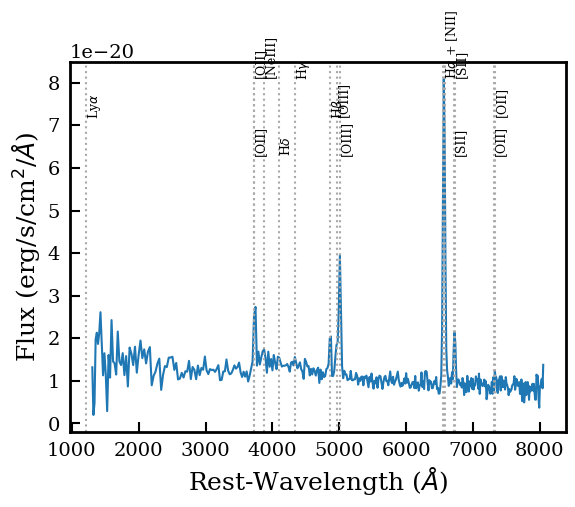

In [148]:
lam0, galaxy0, noise0 = get_dja_spectra(filename, zgal, restframe=True)
plt.plot(lam0[lam0>1300],galaxy0[lam0>1300])
plt.xlabel(f'Rest-Wavelength ($\AA$)')
plt.ylabel(f'Flux (erg/s/cm$^2$/$\AA$)')

##adding line identifiers
lines_plotted=[]
ticker_max = galaxy0.max()
text_hi = ticker_max+1e-20
for kk in range(len(lam_file)):
    lam_idx = np.argmin(np.abs(lam_file['wavelength_nm'][kk]*10-lam0))
    
    if lam_file['wavelength_nm'][kk]*10> lam0.min() and lam_file['wavelength_nm'][kk]*10<lam0.max() and noise0[lam_idx]>0:
        plt.axvline(lam_file['wavelength_nm'][kk]*10, linestyle=':', color='darkgrey')
        if lam_file['line'][kk] not in lines_plotted:
            #lines_plotted.append(lam_file['line'][kk])
            if lam_file['line'][kk] not in ['[NII]']:#if PRISM #'[FeII]','FeII'
                plt.text(lam_file['wavelength_nm'][kk]*10+0.01, text_hi*(0.9-0.1*np.mod(kk,3)), lines_dic[lam_file['line'][kk]], rotation='vertical', fontsize=9)


## get source information with multiple DJA spectra

In [149]:
# Full DJA table

table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.4.csv.gz"
tab00 = utils.read_catalog(download_file(table_url, cache=True), format='csv')



In [150]:
con_sn = tab0['sn']>10
con_sn &= tab0['zsp_best_survey']=='dja'
con_sn &= tab0['zsp_best_avail']>4

tab0[con_sn]['file','objid']

file,objid
str55,float64
gto-wide-uds13-v4_prism-clear_1215_1951.spec.fits,172449.0
capers-cos01-v4_prism-clear_6368_52597.spec.fits,141884.0
rubies-uds23-v4_prism-clear_4233_166691.spec.fits,149974.0
capers-cos04-v4_prism-clear_6368_36571.spec.fits,143258.0
rubies-uds1-v4_prism-clear_4233_37108.spec.fits,151060.0
gto-wide-uds13-v4_prism-clear_1215_1472.spec.fits,162424.0


In [151]:
## check the alternative spectra information

dja_uniq_id = 172449
print(dja_uniq_id)

#search for other dja spectra
msa = tab00[tab00['objid'] == dja_uniq_id]
msa

172449


file,srcid,ra,dec,grating,filter,effexptm,nfiles,dataset,msamet,msaid,msacnf,dithn,slitid,root,npix,ndet,wmin,wmax,wmaxsn,sn10,flux10,err10,sn50,flux50,err50,sn90,flux90,err90,xstart,ystart,xsize,ysize,slit_pa,pa_v3,srcypix,profcen,profsig,ctime,version,exptime,contchi2,dof,fullchi2,line_ariii_7138,line_ariii_7138_err,line_ariii_7753,line_ariii_7753_err,line_bra,line_bra_err,line_brb,line_brb_err,line_brd,line_brd_err,line_brg,line_brg_err,line_hb,line_hb_err,line_hd,line_hd_err,line_hei_1083,line_hei_1083_err,line_hei_3889,line_hei_3889_err,line_hei_5877,line_hei_5877_err,line_hei_7065,line_hei_7065_err,line_hei_8446,line_hei_8446_err,line_heii_4687,line_heii_4687_err,line_hg,line_hg_err,line_lya,line_lya_err,line_mgii,line_mgii_err,line_neiii_3867,line_neiii_3867_err,line_neiii_3968,line_neiii_3968_err,line_nev_3346,line_nev_3346_err,line_nevi_3426,line_nevi_3426_err,line_niii_1750,line_niii_1750_err,line_oi_6302,line_oi_6302_err,line_oii,line_oii_7325,line_oii_7325_err,line_oii_err,line_oiii,line_oiii_1663,line_oiii_1663_err,line_oiii_4363,line_oiii_4363_err,line_oiii_4959,line_oiii_4959_err,line_oiii_5007,line_oiii_5007_err,line_oiii_err,line_pa10,line_pa10_err,line_pa8,line_pa8_err,line_pa9,line_pa9_err,line_paa,line_paa_err,line_pab,line_pab_err,line_pad,line_pad_err,line_pag,line_pag_err,line_pfb,line_pfb_err,line_pfd,line_pfd_err,line_pfe,line_pfe_err,line_pfg,line_pfg_err,line_sii,line_sii_err,line_siii_9068,line_siii_9068_err,line_siii_9531,line_siii_9531_err,spl_0,spl_0_err,spl_1,spl_10,spl_10_err,spl_11,spl_11_err,spl_12,spl_12_err,spl_13,spl_13_err,spl_14,spl_14_err,spl_15,spl_15_err,spl_16,spl_16_err,spl_17,spl_17_err,spl_18,spl_18_err,spl_19,spl_19_err,spl_1_err,spl_2,spl_20,spl_20_err,spl_21,spl_21_err,spl_22,spl_22_err,spl_2_err,spl_3,spl_3_err,spl_4,spl_4_err,spl_5,spl_5_err,spl_6,spl_6_err,spl_7,spl_7_err,spl_8,spl_8_err,spl_9,spl_9_err,zline,line_civ_1549,line_civ_1549_err,line_h10,line_h10_err,line_h11,line_h11_err,line_h12,line_h12_err,line_h7,line_h7_err,line_h8,line_h8_err,line_h9,line_h9_err,line_ha,line_ha_err,line_hei_6680,line_hei_6680_err,line_heii_1640,line_heii_1640_err,line_nii_6549,line_nii_6549_err,line_nii_6584,line_nii_6584_err,line_oii_7323,line_oii_7323_err,line_oii_7332,line_oii_7332_err,line_sii_6717,line_sii_6717_err,line_sii_6731,line_sii_6731_err,line_siii_6314,line_siii_6314_err,escale0,escale1,line_ciii_1906,line_ciii_1906_err,line_niv_1487,line_niv_1487_err,line_pah_3p29,line_pah_3p29_err,line_pah_3p40,line_pah_3p40_err,eqw_ariii_7138,eqw_ariii_7753,eqw_bra,eqw_brb,eqw_brd,eqw_brg,eqw_ciii_1906,eqw_civ_1549,eqw_ha_nii,eqw_hb,eqw_hd,eqw_hei_1083,eqw_hei_3889,eqw_hei_5877,eqw_hei_7065,eqw_hei_8446,eqw_heii_1640,eqw_heii_4687,eqw_hg,eqw_lya,eqw_mgii,eqw_neiii_3867,eqw_neiii_3968,eqw_nev_3346,eqw_nevi_3426,eqw_niii_1750,eqw_niv_1487,eqw_oi_6302,eqw_oii,eqw_oii_7325,eqw_oiii,eqw_oiii_1663,eqw_oiii_4363,eqw_oiii_4959,eqw_oiii_5007,eqw_pa10,eqw_pa8,eqw_pa9,eqw_paa,eqw_pab,eqw_pad,eqw_pag,eqw_pfb,eqw_pfd,eqw_pfe,eqw_pfg,eqw_sii,eqw_siii_9068,eqw_siii_9531,line_ha_nii,line_ha_nii_err,eqw_h10,eqw_h11,eqw_h12,eqw_h7,eqw_h8,eqw_h9,eqw_ha,eqw_hei_6680,eqw_nii_6549,eqw_nii_6584,eqw_oii_7323,eqw_oii_7332,eqw_sii_6717,eqw_sii_6731,eqw_siii_6314,sn_line,ztime,line_ci_9850,line_ci_9850_err,line_feii_11128,line_feii_11128_err,line_pii_11886,line_pii_11886_err,line_feii_12570,line_feii_12570_err,eqw_ci_9850,eqw_feii_11128,eqw_pii_11886,eqw_feii_12570,line_feii_16440,line_feii_16440_err,line_feii_16877,line_feii_16877_err,line_brf,line_brf_err,line_feii_17418,line_feii_17418_err,line_bre,line_bre_err,line_feii_18362,line_feii_18362_err,eqw_feii_16440,eqw_feii_16877,eqw_brf,eqw_feii_17418,eqw_bre,eqw_feii_18362,valid,objid,z_best,ztype,z_prism,z_grating,phot_correction,phot_flux_radius,phot_dr,file_phot,id_phot,phot_mag_auto,phot_f090w_tot_1,phot_f090w_etot_1,phot_f115w_tot_1,phot_f115w_etot_1,phot_f150w_tot_1,phot_f150w_etot_1,phot_f200w_tot_1,phot_f200w_etot_1,phot_f277w_tot_1,phot_f277w_etot_1,phot_f

In [152]:

#  see the description in the https://dawn-cph.github.io/dja/blog/2025/05/01/nirspec-merged-table-v4/
#  
RGB_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}"
msa['metafile'] = [m.split('_')[0] for m in msa['msamet']]
SLIT_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile={metafile}"
FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"

msa['Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        RGB_URL.format(**row['ra','dec'])
    )
    for row in msa
]

msa['Slit_Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        SLIT_URL.format(**row['ra','dec','metafile'])
    )
    for row in msa
]

msa['Spectrum_fnu'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.fnu.png')
    )
    for row in msa
]

msa['Spectrum_flam'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.flam.png')
    )
    for row in msa
]


In [153]:
df = msa['root','file','z_best','phot_mass','eqw_ha_nii','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'].to_pandas()

display(Markdown(df.to_markdown()))

|    | root              | file                                               |   z_best |   phot_mass |   eqw_ha_nii | Thumb                                                                                                                                                                                                        | Slit_Thumb                                                                                                                                                                                                                                                 | Spectrum_fnu                                                                                                                                    | Spectrum_flam                                                                                                                                    |
|---:|:------------------|:---------------------------------------------------|---------:|------------:|-------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | excels-uds01-v4   | excels-uds01-v4_g235m-f170lp_3543_109269.spec.fits |  4.62285 | 3.28099e+10 |       nan    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35062413%2C-5.14987821" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35062413%2C-5.14987821&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw03543001001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/excels-uds01-v4/excels-uds01-v4_g235m-f170lp_3543_109269.fnu.png" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/excels-uds01-v4/excels-uds01-v4_g235m-f170lp_3543_109269.flam.png" height=200px>   |
|  1 | gto-wide-uds13-v4 | gto-wide-uds13-v4_g235h-f170lp_1215_1951.spec.fits |  4.62285 | 3.28099e+10 |       nan    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g235h-f170lp_1215_1951.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g235h-f170lp_1215_1951.flam.png" height=200px> |
|  2 | gto-wide-uds13-v4 | gto-wide-uds13-v4_g395h-f290lp_1215_1951.spec.fits |  4.62285 | 3.28099e+10 |       nan    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g395h-f290lp_1215_1951.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g395h-f290lp_1215_1951.flam.png" height=200px> |
|  3 | gto-wide-uds13-v4 | gto-wide-uds13-v4_prism-clear_1215_1951.spec.fits  |  4.62285 | 3.28099e+10 |      2274.05 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35065901%2C-5.14988767&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_1951.fnu.png" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_1951.flam.png" height=200px>  |

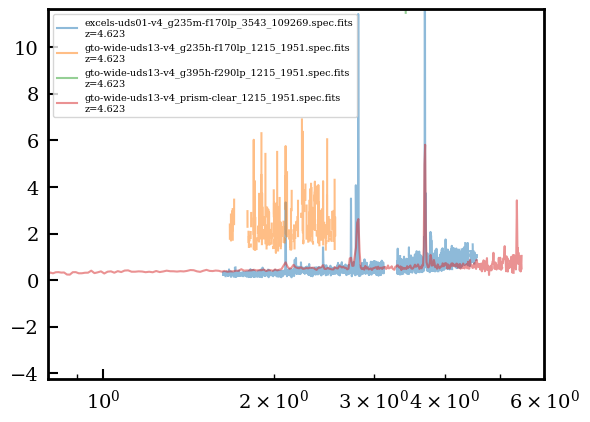

In [154]:
# Reading the spectrum

for i in range(len(df)):
    spec_file = df['file'][i]
    row = msa[msa['file'] == spec_file][0]
    spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))

    ## 
    con_mask = spec['full_err']==0 
    con_mask |= spec['full_err']> spec['flux']

    galaxy_masked = np.ma.masked_where(con_mask, spec['flux'])
    plt.plot(spec['wave'], galaxy_masked,
         label="{file}\nz={z_best:.3f}".format(**row), alpha=0.5)


plt.xlim([0.8,6])
plt.ylim(top=galaxy_masked.max()*2)
plt.semilogx()
plt.legend(fontsize=7, ncol=1)